(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,
         1.,  0.,  1.,  2.,  0.,  1.,  2.,  3.,  0.,  3.,  5.,  4.,  3.,
         4.,  9.,  8.,  7.,  8.,  5.,  9., 12., 18., 12.,  8., 13., 20.,
        21., 16., 20., 24., 20., 26., 29., 22., 29., 32., 20., 28., 29.,
        33., 27., 18., 29., 29., 18., 25., 29., 21., 29., 21., 22., 22.,
        20., 19., 13., 14., 15., 15.,  8., 13.,  9., 11.,  7.,  6.,  6.,
         5.,  6.,  7.,  4.,  1.,  0.,  4.,  4.,  4.,  1.,  1.,  1.,  2.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.13342093, 0.14041519, 0.14740944, 0.1544037 , 0.16139796,
        0.16839221, 0.17538647, 0.18238073, 0.18937498, 0.19636924,
        0.2033635 , 0.21035775, 0.21735201, 0.22434627, 0.23134052,
        0.23833478, 0.24532904, 0.25232329, 0.25931755, 0.26631181,
        0.27330606, 0.28030032, 0.28729458, 0.29428883, 0.30128309,
        0.30827735, 0.3152716 , 0.32226586, 0.32926012, 0.33625437,
        0.34324863, 0.3502

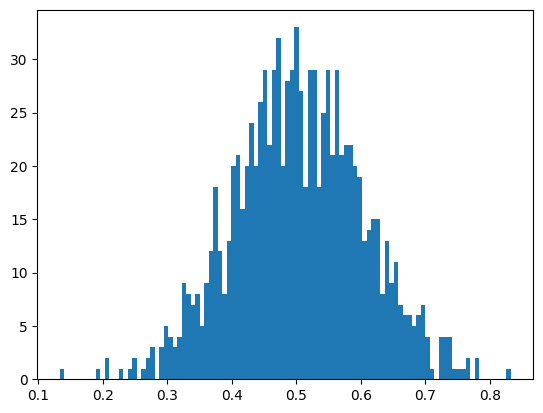

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Number of agents
N = 1000

# Wealth
wealth_arr = abs(np.random.normal(0.5, 0.1, N))
plt.hist(wealth_arr, bins=100)  

(array([57., 72., 61., 58., 56., 51., 48., 50., 49., 36., 35., 28., 30.,
        30., 25., 25., 23., 22., 26., 16., 15., 18.,  8., 10., 10., 11.,
         8.,  4.,  9.,  5.,  5., 10.,  5., 10.,  5.,  4.,  9.,  8.,  7.,
         2.,  1.,  3.,  4.,  1.,  6.,  0.,  1.,  1.,  1.,  4.,  2.,  3.,
         1.,  1.,  2.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.29987674e-04, 3.74567155e-02, 7.45834433e-02, 1.11710171e-01,
        1.48836899e-01, 1.85963627e-01, 2.23090355e-01, 2.60217083e-01,
        2.97343810e-01, 3.34470538e-01, 3.71597266e-01, 4.08723994e-01,
        4.45850722e-01, 4.82977450e-01, 5.20104177e-01, 5.57230905e-01,
        5.94357633e-01, 6.31484361e-01, 6.68611089e-01, 7.05737817e-01,
        7.42864544e-01, 7.79991272e-01, 8.17118000e-01, 8.54244728e-01,
  

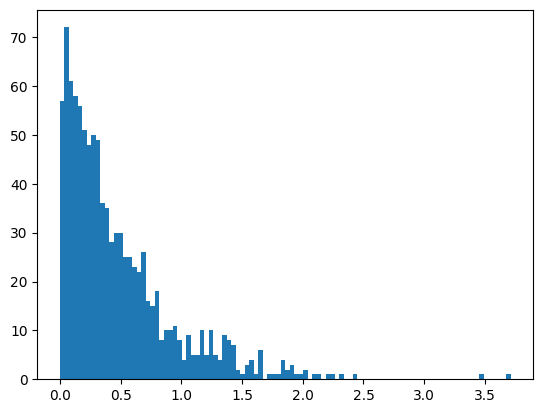

In [35]:
import random
N = 1000
alpha = 1
beta = 0.5

wealth_arr = np.array([random.gammavariate(alpha, beta) for i in range(N)])
plt.hist(wealth_arr, bins=100)

In [36]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

gini(wealth_arr)

np.float64(0.48504377614861505)

In [37]:
X = wealth_arr
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]


(np.float64(0.0), np.float64(1.0000000000000007))

Text(0.5, 1.0, 'Lorenz curve')

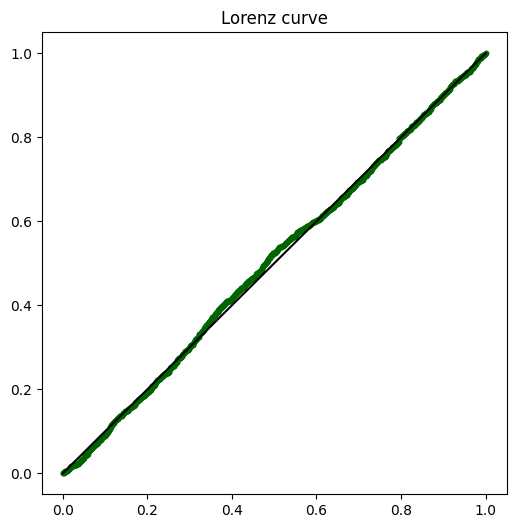

In [38]:
fig, ax = plt.subplots(figsize=[6,6])

ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='darkgreen', s=10)
ax.plot([0,1], [0,1], color='k')
ax.set_title('Lorenz curve')
 

In [39]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        self.wealth = model.wealth_arr[unique_id]
        
    def step(self):
        if self.criminal:  
            return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth - self.wealth > self.model.deterrence:
            self.criminal = True

            stolen_amount = self.random.random() * other_agent.wealth
            self.wealth += stolen_amount 
            other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate},
            agent_reporters={"Criminal": "criminal", "Wealth": "wealth"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [40]:
model = CrimeModel(N, 0.8, wealth_arr)

while model.schedule.steps < 100:
    model.step()


C:\Users\nxg05271\AppData\Local\Temp\ipykernel_32180\2432237556.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [41]:
model.datacollector.get_agent_vars_dataframe()

Criminal
Step AgentID          
0    0           False
     1           False
     2           False
     3           False
     4           False
...                ...
99   421          True
     874         False
     808         False
     566         False
     521         False

[100000 rows x 1 columns]

In [42]:
model.datacollector.get_model_vars_dataframe()

,Crime rate
0,0.000
1,0.062
2,0.135
3,0.200
4,0.239
...,...
95,0.494
96,0.495
97,0.495
98,0.495


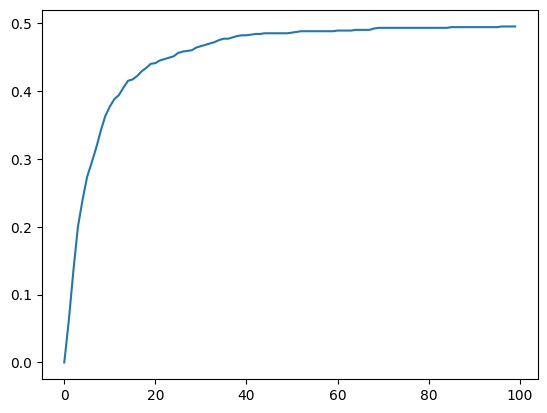

In [43]:
plt.plot(model.datacollector.get_model_vars_dataframe())